In [1]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import networkx as nx
from IPython.display import Image
from scipy.spatial.distance import cdist, pdist, squareform

import collections
from operator import attrgetter

#set random seed
np.random.seed(300)

# load wheel point cloud
wheel = np.genfromtxt('data/wheel.txt', delimiter=' ')

# select random indicies from the point cloud
random_indices = np.random.choice(wheel.shape[0], 200)

# subset of the point cloud
subcloud = wheel[random_indices, ]

## Part 5. The 1-dimensional persistence

The idea of analysing a point cloud across all scales will be formalized below through the concept of persistence. 

When the scale increases, the union of disks (offset $C^{\alpha}$) grows and its topological shape changes. 

The picture below shows how the shape of $C^{\alpha}$ becomes connected, encloses the first hole (a bounded component of the complement ${\mathbb R}^2-C^{\alpha}$) and then this hole splits into two smaller holes.

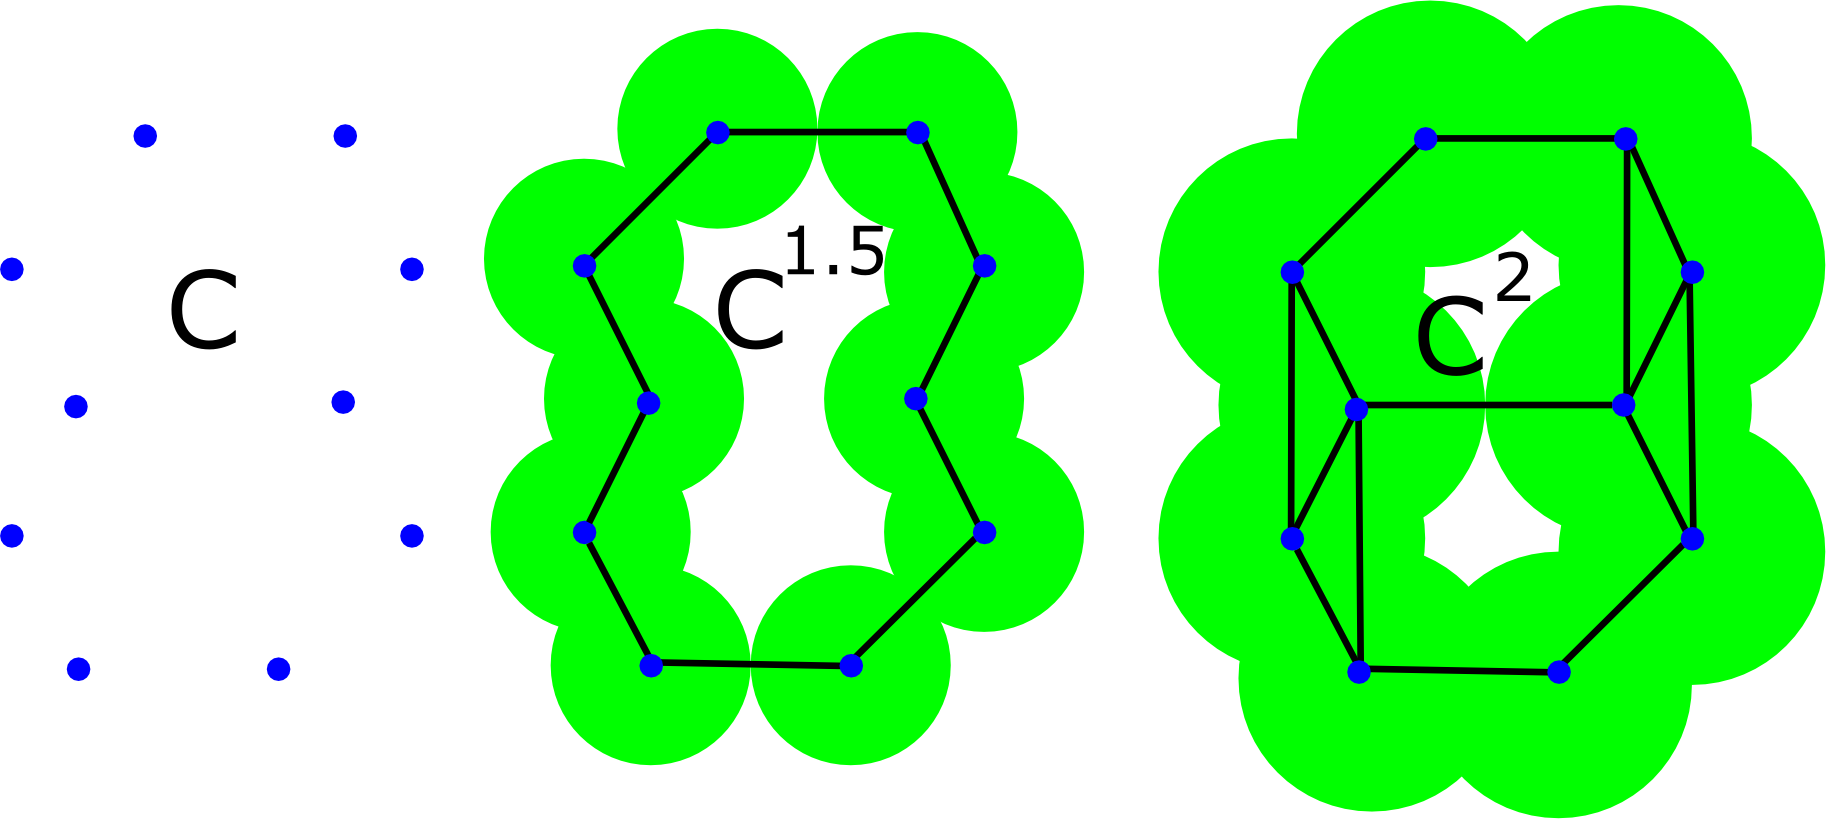

In [2]:
Image(filename='data/img/figure-eight-offsets.png')

### 5.1. Offsets of a cloud deform to complexes

The offset (a union of balls) of a point cloud has a rather complicated geometric shape, which is hard to determine and store in a computer memory.

The following result explains why $\alpha$-complexes were invented as correct topological representatives of geometric offsets.

<b>Theorem</b> (a corollary of the more general nerve theorem). For any point cloud $C\subset{\mathbb R}^n$ and any scale $\alpha>0$, the $\alpha$-offset $C^{\alpha}$ continously deforms to the $\alpha$-complex $C(\alpha)\subset Del(C)$.

The continuous deformation in the above theorem has a more rigorous name of a deformation retraction and implies that any complicated $\alpha$-offset $C^{\alpha}$ and the much simpler combinatorial $\alpha$-complex $C(\alpha)$ have the same homotopy type (roughly the same continuous shape).

The next step is to study the evolution of topological features (invariants) in a sequence of complexes (or shapes) across all scales. 

### 5.2. The 0-dimensional persistence of a cloud

Topology in dimension 0 is about connected components. We have seen a reduced $MST(C;\alpha)$, a possibly disconnected graph that has the vertex set $C$, a minimum total length and contains only edges of lengths at most $\alpha$.

When the scale $\alpha$ increases from $0$ to $+\infty$, the reduced $MST(C;\alpha)$ grows from the set of $n$ isolated points of $C$ to a Minimum Spaning Tree $MST(C)$.

When a new edge is added to $MST(C;\alpha)$ at a scale $\alpha$, two connected components merge and we say that one (any) of them dies, while the other continues to grow. 

Then each connected component grows from scale 0 (as an isolated point at its <i>birth</i>) to its <i>death</i> scale (when it merges with another component). The only exception is a full $MST(C)$, which never dies after the scale $\alpha$ becomes sufficiently large. 

In practice, a Minimum Spanning Tree can be computed by a <a href="https://en.wikipedia.org/wiki/Disjoint-set_data_structure">union-find algorithm</a>, which dynamically maintains connectivity of a graph when new edges are added. This algorithm will be used in the final part for the dual graph of $\alpha$-complexes to compute the 1D persistence.

The <i>0D persistence</i> of a cloud $C$ of $n$ points can be defined as an ordered sequence of death scales (merge times) equal to the lengths $l_1\leq l_2\leq\dots\leq l_{n-1}$ (or half-lengths depending on a convention) of edges in $MST(C)$.

Visually, the 0D persistence diagram in this case can be drawn as a set of the dots (birth,death) $=(0,l_i)$, $i=1,\dots,n$ in the vertical death axis on the plane.

The code below outputs $MST(C)$ for the 10-point cloud $C$, which we have used earlier. Feel free to change coordinates of points in a cloud $C$ to see how a Minimum Spannin Tree $MST(C)$ is updated below.

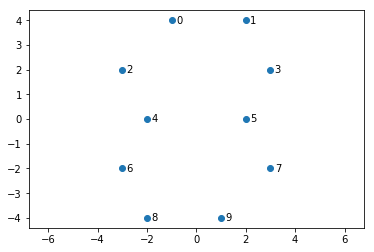

In [12]:
points = np.array([[-1, 4], [2, 4], [-3, 2], [3, 2], [-2, 0],
                   [2,0], [-3, -2], [3, -2], [-2, -4], [1, -4]])
plt.plot(points[:,0], points[:,1], 'o')
for i,p in enumerate(points):
    plt.text(p[0]+0.3, p[1], i, ha="center", va="center")
plt.axis('equal')
plt.show()

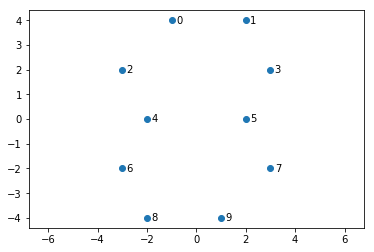

In [21]:
points = np.array([[-1, 4], [2, 4], [-3, 2], [3, 2], [-2, 0],
                   [2,0], [-3, -2], [3, -2], [-2, -4], [1, -4]])
plt.plot(points[:,0], points[:,1], 'o')
for i,p in enumerate(points):
    plt.text(p[0]+0.3, p[1], i, ha="center", va="center")
plt.axis('equal')
plt.show()

In [14]:
# create a pairwise distance matrix for the subcloud
X = squareform(pdist(points))
# create a complete graph from the distance matrix, with edge
# lengths equal to the distance between points
G = nx.from_numpy_matrix(X)
X.shape

(10, 10)

In [15]:
for edge in nx.minimum_spanning_edges(G):
    print(0, edge[2]['weight'])

0 2.23606797749979
0 2.23606797749979
0 2.23606797749979
0 2.23606797749979
0 2.23606797749979
0 2.23606797749979
0 2.8284271247461903
0 2.8284271247461903
0 3.0


In [16]:
def plot_diagram(dgm, show = False, labels = False):
    """Plot the persistence diagram."""

    inf = float('inf')
    min_birth = min(p.birth for p in dgm if p.birth != inf)
    max_birth = max(p.birth for p in dgm if p.birth != inf)
    min_death = min(p.death for p in dgm if p.death != inf)
    max_death = max(p.death for p in dgm if p.death != inf)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    ax.set_aspect('equal', 'datalim')

    min_diag = min(min_birth, min_death)
    max_diag = max(max_birth, max_death)
    ax.scatter([p.birth for p in dgm], [p.death for p in dgm])
    ax.plot([min_diag, max_diag], [min_diag, max_diag])        # diagonal

    if labels:
        ax.set_xlabel("birth")
        ax.set_ylabel("death")

    return plt.show()

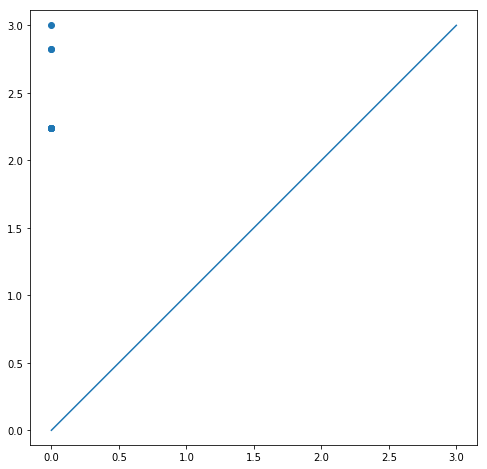

In [17]:
# create a named tuple
Point = collections.namedtuple('Point', 'birth death')

# get the persitence points for the 0th dimension
# where the birth is always 0 and death is the length of the 
# edge connecting two separate components
persistence_points = [Point(0, edge[2]['weight']) for edge in nx.minimum_spanning_edges(G)]

# plot the diagram
plot_diagram(persistence_points)

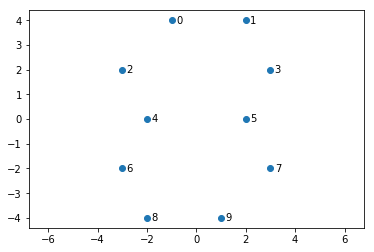

In [22]:
b

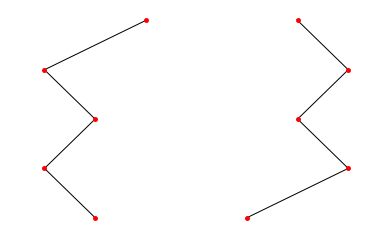

In [27]:
def reduced_MST(G, alpha):
    
    # create graph with no edges
    # with the same nodes as G
    graph = nx.Graph()
    graph.add_nodes_from(G)
    
    for edge in nx.minimum_spanning_edges(G):
        if edge[2]['weight'] >= alpha:
            break
        # if the edge is not greater than alpha
        # add it to the graph
        graph.add_edge(edge[0], edge[1])
        
    return graph

# get reduced tree
threshold = 2.9
tree = reduced_MST( G, threshold )

# plot the spanning tree
ax = plt.subplot(111)
nx.draw( tree, pos, node_size=15, ax=ax )
plt.show()

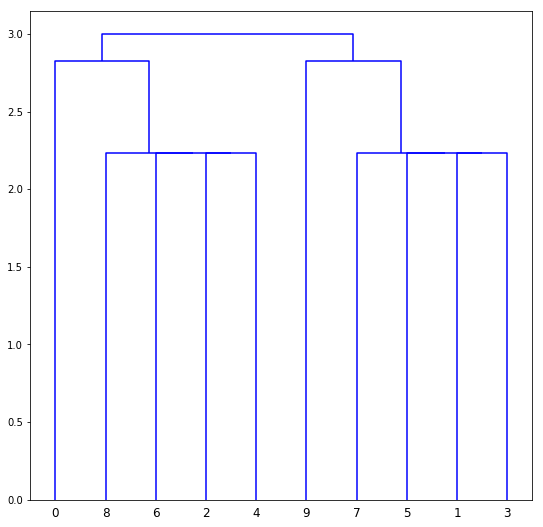

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
distance_matrix = pdist(points)
l = linkage(distance_matrix, method='single')
f1, ax1 = plt.subplots(1, figsize=(9, 9))
dn = dendrogram(l, ax=ax1)

A persistence diagram may contain multiple points at the same location. For example, the lowest point (0, 2.23606797749979) in the diagram above has multiplicity 6. This means that $MST(C)$ has 6 edges of the same length 2.23606797749979.

### 5.3. One-dimensional cycles in complexes

Topology in dimension 1 is about non-trivial cycles. For a complex consisting of edges and triangles (or higher dimensional simplices), a <i>cycle</i> is a sequence of edges starting and finishing at the same vertex.

A cycle is called (homologically) <i>non-trivial</i> if it is not the only boundary of a 2D triangulated surface within a complex. For example, the boundary of a solid 2D triangle is trivial.

However, the triangular cycle without the added solid 2D triangle is non-trivial, because the triangular hole acts as a topological obstacle.

Similarly, the long cycle in the middle picture below is non-trivial, because the complex $C(1.5)$ has no triangles whose boundaries can form the cycle.

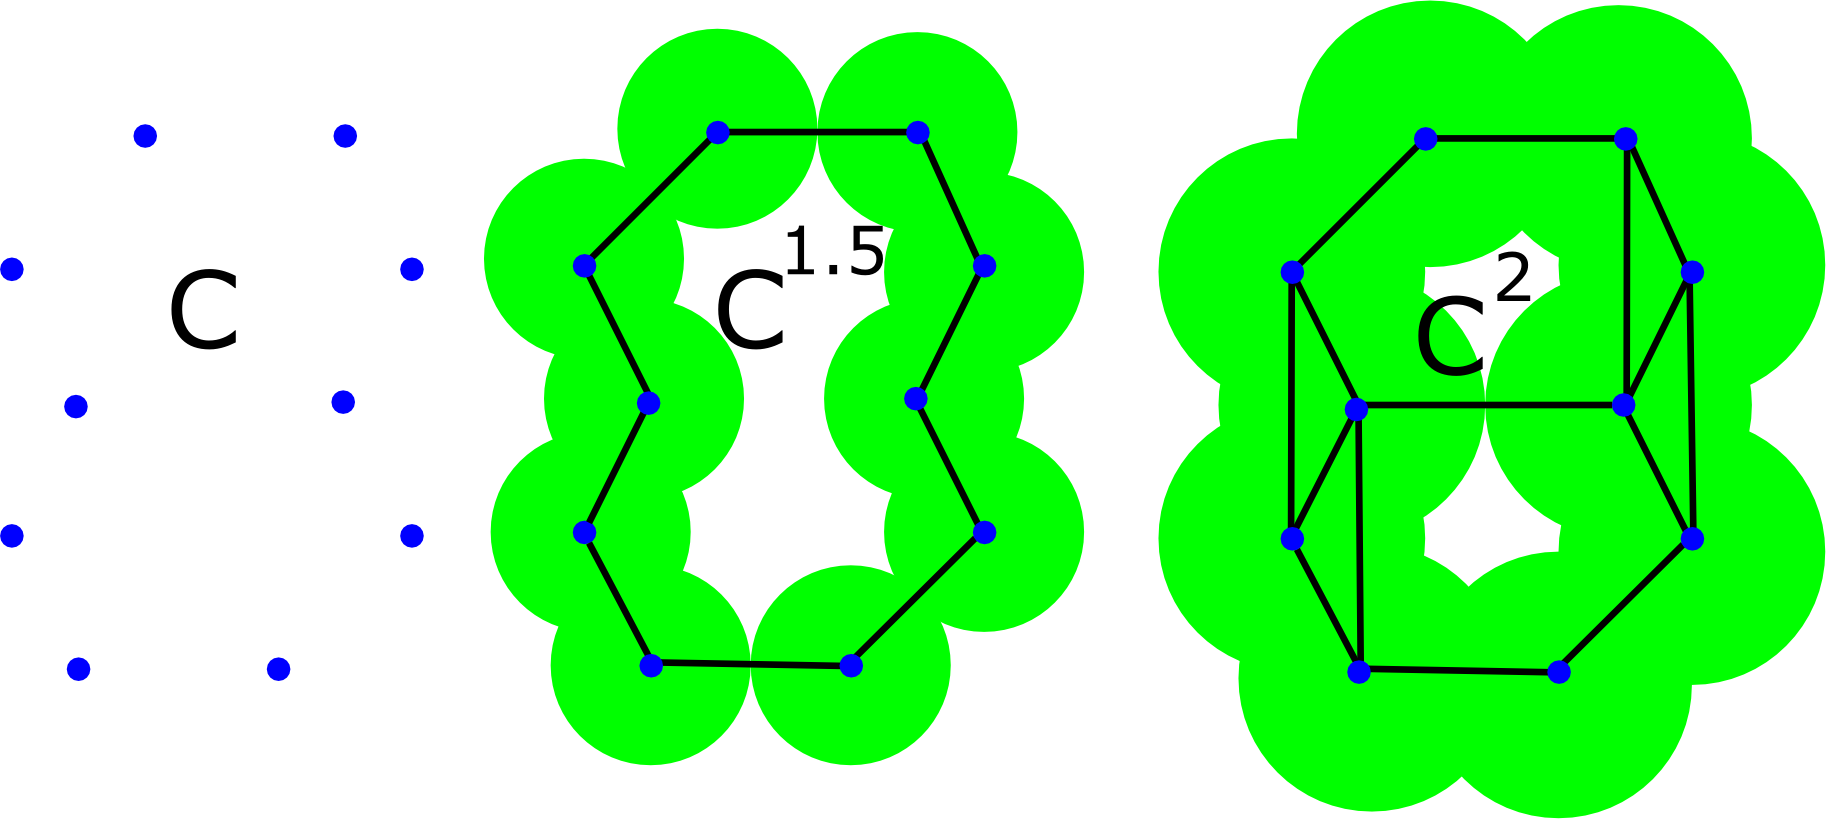

In [9]:
Image(filename='data/img/figure-eight-offsets.png')

The above picture on the right shows more cycles. Narrow triangular cycles are completely filled by green disks, hence bounded by the green triangles and are trivial. 

However, two pentagonal cycles enclose white holes (bounded components of the complement ${\mathbb R}^2-C^2$) and are non-trivial within the offset $C^2$ and the $\alpha$-complex $C(2)$.

These white holes become filled for a larger value of $\alpha\approx 2.6$ (more exactly, for $\alpha$ equal to the largest circumradius of Delaunay triangules) in the larger offset $C^{\alpha}$ or complex $C(\alpha)$.

### 5.4. The 1D persistence diagram

When a non-trivial cycle appears in a sequence (filtration) of complexes $C(\alpha)$, we say that the cycle is <i>born</i> at the scale $\alpha$ or has the <i>birth</i> $=\alpha$.

The same cycle can be considered within the larger complexes $C(\alpha')$ for any scale $\alpha'>\alpha$. If this cycle becomes trivial or continuously deformable (through existing triangles) to other cycles within $C(\alpha')$ at the larger scale $\alpha'$, we say that the cycle <i>dies</i> at the scale $\alpha'$ or has the <i>death</i>  $=\alpha'$.

So every non-trivial cycle in a filtration of complexes $C(\alpha)$ has a life span from its birth $\alpha$ to its death $\alpha'$, which can be represented by the interval $[\alpha,\alpha')$ or by a blue bar in the middle picture below.

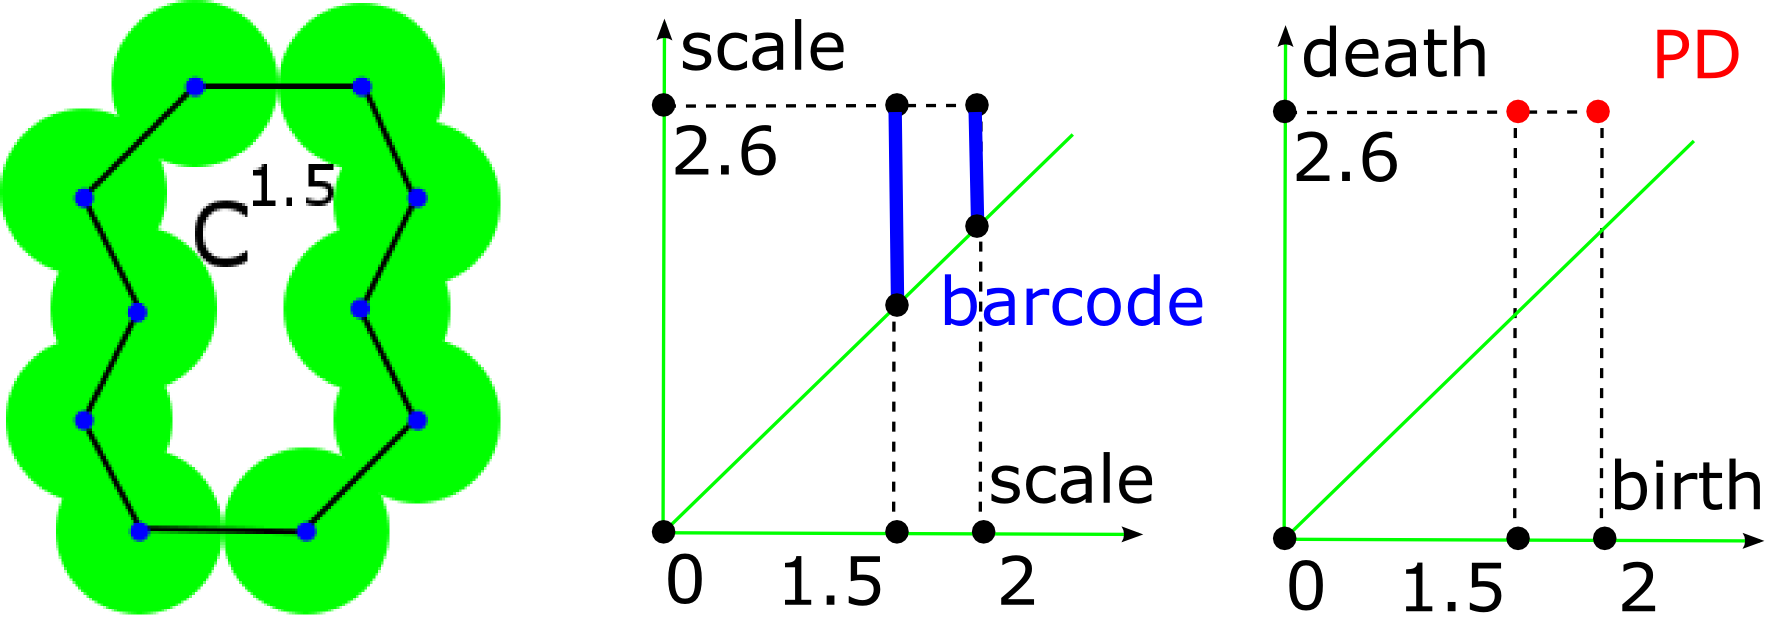

In [10]:
Image(filename='data/img/figure-eight-persistence.png')

When a large hole in $C^{1.5}$ (enclosed by a non-trivial cycle) splits into two smaller holes, we say that a new hole (one of two smaller ones) is born and the previous big hole continues its life as another small hole. 

This splitting of holes is formalized through linear maps between vector spaces (sets of non-trivial cycles considered up to continuous deformations) induced by inclusions $C(\alpha)\subset C(\alpha')$. 

In details, the space $H_1(C(1.5))$ of 1D cycles has only one basis vector (a non-trivial cycle). The space $H_1(C(2))$ has two basis vectors (two independent 1D cycles). The inclusion $C(1.5)\subset C(2)$ induces the linear map $H_1(C(1.5))\to H_1(C(2))$, which sends the big cycle into the "sum" $A+B$ of two smaller cycles (vectors). The big cycle $A+B$ can be still considered as a basis vector (of the larger 2-dimensional space) together with another basis vector, say $A$ for one of two smaller holes. 

Instead of the blue bars, we can represent each life span $[birth,death)$ by a single red dot with two coordinates (birth,death) in the above picture on the right. All such red dots lie in the upper half-plane above the diagonal because death $\geq$ birth.

<b>Definition</b>. The <i>persistence diagram</i> (of a filtration of complexes on a point cloud $C$) consists of all dots (birth,death) representing life spans of non-trivial cycles during the evolution of complexes on $C$.  

### 5.5. Stability of persistence

Apart from the above rigorous definition (formally based on a classification of graded modules over a field), the persistence has the major advantage of being stable under perturbations.

<b>Stability theorem</b> (Cohen-Steiner, Edelsbrunner, Harer, 2007) briefly says that if we perturb a cloud $C$ to another cloud $D$ "within $\epsilon$" (more formally, $C\subset D^{\epsilon}$ and $D\subset C^{\epsilon}$), then the persistance diagrams (in any dimension) of $C$ and $D$ are also "$\epsilon$-close", formally the so-called bottleneck distance between them is at most $\epsilon$, see the illustration below.

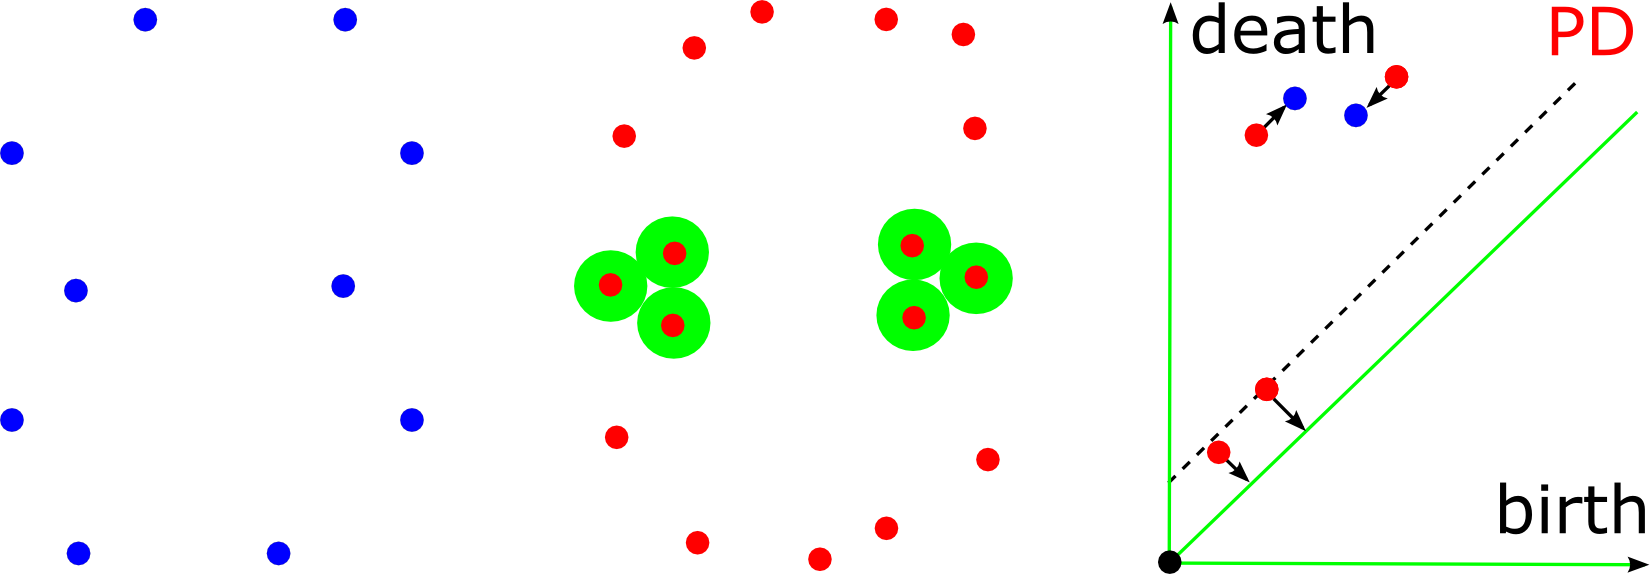

In [11]:
Image(filename='data/img/figure-eight-stability.png')

The above picture on the right shows an $\epsilon$-matching of dots between two persistence diagrams. Some dots are matched to diagonal points corresponding to features of persistence 0.

The <i>persistence</i> of a topological feature is measured as death$-$birth. Dots with high persistence (away from the diagonal) represent highly persistent features. Dots with low persistence (close to the diagonal) represent noisy artefacts.